# Example of loading and analyzing REMA data

## This is based on another notebook (dask_drainagebasins.ipynb) that computes drainage basins from the Reference Digitial Elevation Model of Antarctica (REMA). 

## This version is simplified to make demonstration in a presentation easier. 

# 1. Import packages and define functions

In [3]:
from dask.distributed import Client
#from dask.diagnostics import ProgressBar
import dask
import dask.delayed
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da
import numpy as np
import xarray as xr
import geopandas as gpd
#import hvplot.xarray
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import math
import scipy.sparse
#import shapefile
import shapely
import os

# define some functions
%run ./Function_defs.ipynb

<ipython-input-3-9aa1a33bf05f>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [21]:
dask_gateway.__version__

# show the default dask-gateway settings
dask.config.config['gateway']

#default gateway call
gateway = Gateway()

orphaned_cluster_name = gateway.list_clusters()[0].name
orphaned_cluster_name
gateway.stop_cluster(orphaned_cluster_name)


In [1]:
gateway.list_clusters

NameError: name 'gateway' is not defined

# 2. Open google cloud cluster

In [8]:
# get the dask-gateway version
dask_gateway.__version__
# show the default dask-gateway settings
dask.config.config['gateway']
#default gateway call
gateway = Gateway()
# default new_cluster call
cluster = gateway.new_cluster()
# the dashboard_link property will show the link that can be pasted into the Dask labextension
cluster.dashboard_link
# scale cluster to 8 workers using the scale() method
# cluster.scale(8)
# connect a client
# the distributed client is used for running parallel tasks with Dask
client = Client(cluster)

In [15]:
## Scale cluster and connect a client
## "cluster" will show the interactive scaling controls and the dashboard link, which can be pasted into the Dask labextension.
cluster.scale(48)
cluster

# 3. Choose an ice shelf and load info about its extent
### for this example we choose Amery Ice Shelf

<AxesSubplot:>

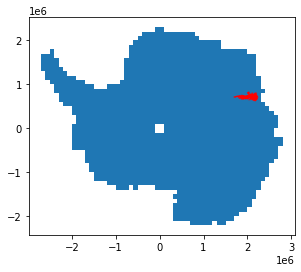

In [27]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 
#select an ice shelf, the Amery Ice Shelf in east Antarctica
Amery = IS[IS.NAME=='Amery']
#read in the REMA tile index
REMA_index = gpd.read_file('REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')
#bounding box of ice shelf
[minx,miny,maxx,maxy]= Amery.bounds.values.tolist()[0]
bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

# find which REMA tile overlap with the ice shelf
IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

row=np.zeros((len(IS_tiles),1))
col=np.zeros((len(IS_tiles),1))
for i in np.arange(0,len(IS_tiles)):
    [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')

row = np.int_(row)
col = np.int_(col)

# plot 
fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
Amery.geometry.plot(ax=axis,color='r')

# 4. 'Lazily' load the REMA tiles that overlap with the ice shelf

In [47]:
#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in range(row.max()-1, row.min()-1, -1): 
    cols = []
    for j in tqdm(range(col.min(),col.max())):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)
    
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds_array = ds.squeeze()
ds_array

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray (y: 25000, x: 75000)>
dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 8e+05 8e+05 8e+05 8e+05 ... 6e+05 6e+05 6e+05 6e+05
  * x        (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06
Attributes:
    transform:           (8.0, 0.0, 1600000.0, 0.0, -8.0, 800000.0)
    crs:                 +init=epsg:3031
    res:                 (8.0, 8.0)
    is_tiled:            1
    nodatavals:          (-9999.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

# 5. Compute the mean

In [48]:
%%time
mean_z = ds_array.mean()
mean_z.compute()

CPU times: user 101 ms, sys: 6.8 ms, total: 108 ms
Wall time: 12.1 s


<xarray.DataArray ()>
array(459.5508, dtype=float32)
Coordinates:
    band     int64 1

# 6.  Do something slightly more complex: Coursen the data, subsample it and then plot it

In [30]:
masked_array = ds_array
coarsed_masked_array = masked_array.coarsen(x=100,y=100).mean()
coarsed_masked_array = coarsed_masked_array.chunk((25,25))
sample  = coarsed_masked_array[:,0:300]
sample

<xarray.DataArray (y: 250, x: 300)>
dask.array<getitem, shape=(250, 300), dtype=float32, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 7.996e+05 7.988e+05 7.98e+05 ... 6.012e+05 6.004e+05
  * x        (x) float64 1.6e+06 1.601e+06 1.602e+06 ... 1.839e+06 1.84e+06

# 6. Compute this operation and plot to confirm we have managed to get something that looks like elevation data

In [23]:
sample.compute()

<xarray.DataArray (y: 250, x: 300)>
array([[1494.0522, 1489.7012, 1485.6013, ...,       nan,       nan,
              nan],
       [1489.8365, 1484.9222, 1480.3044, ...,       nan,       nan,
              nan],
       [1485.7164, 1480.7762, 1475.4172, ...,       nan,       nan,
              nan],
       ...,
       [1407.9138, 1411.7106, 1412.8549, ...,       nan,       nan,
              nan],
       [1404.2808, 1410.258 , 1409.6135, ...,       nan,       nan,
        1042.7156],
       [1404.9415, 1408.9373, 1405.6312, ..., 1079.3606, 1074.25  ,
        1061.8468]], dtype=float32)
Coordinates:
    band     int64 1
  * y        (y) float64 7.996e+05 7.988e+05 7.98e+05 ... 6.012e+05 6.004e+05
  * x        (x) float64 1.6e+06 1.601e+06 1.602e+06 ... 1.839e+06 1.84e+06

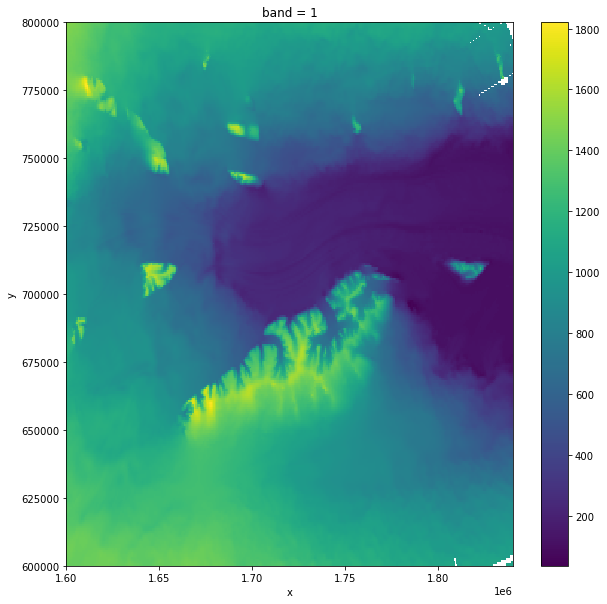

In [32]:
sample = sample.persist()
fig, ax = plt.subplots(figsize=(10,10))
sample.plot()

In [33]:
nhood = np.ones((3,3))
identified_flats = sample.data.map_overlap(lambda dem: identifyflats(dem), depth=0)
                                                       
flats = identified_flats.persist()
identified_sills = dask.array.map_overlap(lambda dem,flats: identifysills(dem,flats), sample.data, flats, depth=1, dtype=float, align_arrays=True)#identifysills(sample_and_flats) #still would like to do this chunkwise

sills = identified_sills.persist()

identified_interbasins = sample.data.map_overlap(lambda dem: identifyinteriorbasins(dem), depth=1, dtype=float)
interiorbasins = identified_interbasins.persist()

cellsize = 200*100
FlowObj_dask = lambda dem,flats,sills,interiorbasins: drainagebasins(dem,flats,sills,interiorbasins,cellsize)
FlowObj_values = dask.array.map_overlap(FlowObj_dask,sample.data,flats,sills,interiorbasins,dtype=float, depth=24, align_arrays=True)

In [34]:
FlowObj_values 

dask.array<_trim, shape=(250, 300), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>

NameError: name 'FlowObj_valueschunk' is not defined

NameError: name 'D_new' is not defined

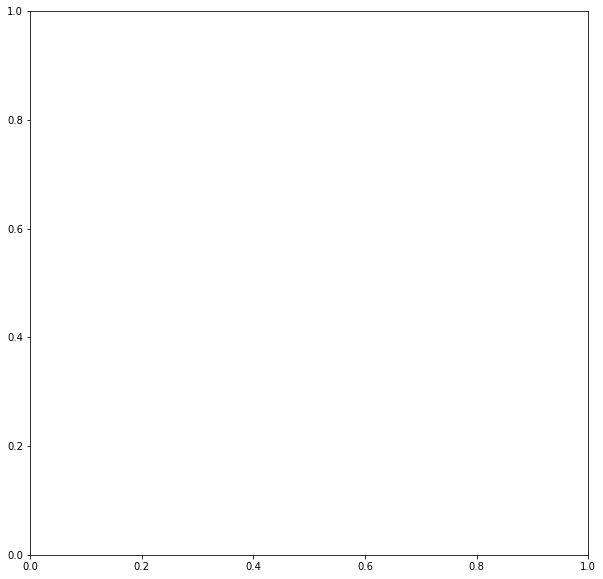

In [35]:
#D = FlowObj_values.compute()
#D_new = cleandrainagebasins(D)
fig, ax = plt.subplots(figsize=(10,10))
D_new.plot(ax=ax)
Amery.plot(ax=ax, facecolor='None',edgecolor='r')

In [20]:
cluster.close()